In [71]:
import sklearn as sk
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [72]:
# Loading data and check if it's loaded properly
df = pd.read_csv("Paitients_Files_Train.csv", delimiter=",")
print(df.head(5))

          ID  PRG   PL  PR  SK   TS   M11    BD2  Age  Insurance   Sepssis
0  ICU200010    6  148  72  35    0  33.6  0.627   50          0  Positive
1  ICU200011    1   85  66  29    0  26.6  0.351   31          0  Negative
2  ICU200012    8  183  64   0    0  23.3  0.672   32          1  Positive
3  ICU200013    1   89  66  23   94  28.1  0.167   21          1  Negative
4  ICU200014    0  137  40  35  168  43.1  2.288   33          1  Positive


In [73]:
# rename the column so that it's easier to evaluate them later
columns = {
    "PRG": "BGlucose",
    "PR": "BPressure",
    "PL": "B1",
    "SK": "B2",
    "TS": "B3",
    "BD2": "B4",
    "M11": "BMI"
}
df = df.rename(columns=columns)

In [74]:
# drop 2 irrelevant columns: ID and Insurance
df.drop(columns="ID", inplace=True)
df.drop(columns="Insurance", inplace=True)

In [75]:
X = df.drop(columns="Sepssis")
Y = df[["Sepssis"]]

In [76]:
Y.value_counts()

Sepssis 
Negative    391
Positive    208
dtype: int64

In [77]:
import numpy as np
for col in X.columns:
    percentiles = X[col].quantile([0.01, 0.99]).values
    df[col] = np.clip(X[col], percentiles[0], percentiles[1])

In [78]:
Y.value_counts()

Sepssis 
Negative    391
Positive    208
dtype: int64

In [79]:
# Encode target value

from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
Y = label_encoder.fit_transform(Y.to_numpy().ravel())

print(Y[:5])

[1 0 1 0 1]


In [80]:
# spliting
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=6, test_size=0.2)
print("Training X:", X_train.shape)
print("Testing X: ",X_test.shape)
print("Train Y: ",y_train.shape)

Training X: (479, 8)
Testing X:  (120, 8)
Train Y:  (479,)


In [96]:
# define pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn import metrics

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import ADASYN, SVMSMOTE, SMOTE
from imblearn.under_sampling import NeighbourhoodCleaningRule, RandomUnderSampler

over = SVMSMOTE(sampling_strategy="minority")
# under = NeighbourhoodCleaningRule(n_neighbors=4, threshold_cleaning=0.5)
# under = RandomUnderSampler(random_state=1)

dtree_model = DecisionTreeClassifier(max_features="sqrt", random_state=4, ccp_alpha=0.0032)
steps = [('over', over),('model', dtree_model)]
pipeline = Pipeline(steps=steps)

X_train_over, y_train_over = over.fit_resample(X_train, y_train)
path = dtree_model.cost_complexity_pruning_path(X_train_over, y_train_over)
ccp_alphas, impurities = path.ccp_alphas, path.impurities



Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

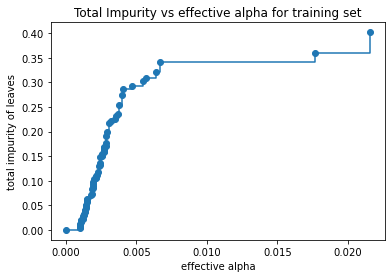

In [97]:
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker="o", drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

Number of nodes in the last tree is: 1 with ccp_alpha: 0.03264163506424036


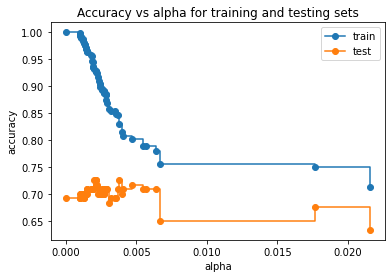

In [98]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(max_features="sqrt",random_state=4, ccp_alpha=ccp_alpha)
    clf.fit(X_train_over, y_train_over)
    clfs.append(clf)

print("Number of nodes in the last tree is: {} with ccp_alpha: {}".format(clfs[-1].tree_.node_count, ccp_alphas[-1]))
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

train_scores = [clf.score(X_train_over, y_train_over) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker="o", label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker="o", label="test", drawstyle="steps-post")
ax.legend()
plt.show()

In [121]:

param_grid = {
    "model__class_weight": [{0:0.42,1:0.58}, {0:0.45,1:0.55},{0:0.49,1:0.51},{0:0.5,1:0.5}],
    "model__ccp_alpha": [0.0,0.002,0.0025,0.003,0.0035],
    "model__max_depth": [2,3,4,5],
    "model__min_samples_leaf": [1,2,3,4,5],
    "model__min_samples_split": [2,3,4,5]

}
search = GridSearchCV(pipeline, param_grid, scoring="f1",cv=10, error_score="raise")
search.fit(X_train, y_train)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

Best parameter (CV score=0.675):
{'model__ccp_alpha': 0.0025, 'model__class_weight': {0: 0.42, 1: 0.58}, 'model__max_depth': 4, 'model__min_samples_leaf': 5, 'model__min_samples_split': 2}


In [124]:
dtree_model = DecisionTreeClassifier(max_features="sqrt",
class_weight={0: 0.5, 1: 0.5}, 
random_state=4, 
ccp_alpha=0.0025,
max_depth=4,
min_samples_leaf=5,
min_samples_split=2)
steps = [('over', over), ('model', dtree_model)]

pipeline = Pipeline(steps=steps)
pipeline.fit(X_train, y_train)

Pipeline(steps=[('over', SVMSMOTE(sampling_strategy='minority')),
                ('model',
                 DecisionTreeClassifier(ccp_alpha=0.0025,
                                        class_weight={0: 0.5, 1: 0.5},
                                        max_depth=4, max_features='sqrt',
                                        min_samples_leaf=5, random_state=4))])

In [112]:
text_ = tree.export_text(dtree_model,feature_names=['BGlucose', 'B1', 'BPressure', 'B2', 'B3', 'BMI', 'B4', 'Age'])
print(text_)

|--- BGlucose <= 6.50
|   |--- Age <= 24.50
|   |   |--- B1 <= 130.50
|   |   |   |--- B1 <= 101.50
|   |   |   |   |--- class: 0
|   |   |   |--- B1 >  101.50
|   |   |   |   |--- class: 0
|   |   |--- B1 >  130.50
|   |   |   |--- B2 <= 23.50
|   |   |   |   |--- class: 1
|   |   |   |--- B2 >  23.50
|   |   |   |   |--- class: 1
|   |--- Age >  24.50
|   |   |--- BMI <= 26.63
|   |   |   |--- B1 <= 162.50
|   |   |   |   |--- class: 0
|   |   |   |--- B1 >  162.50
|   |   |   |   |--- class: 1
|   |   |--- BMI >  26.63
|   |   |   |--- B1 <= 103.50
|   |   |   |   |--- class: 0
|   |   |   |--- B1 >  103.50
|   |   |   |   |--- class: 1
|--- BGlucose >  6.50
|   |--- BMI <= 26.30
|   |   |--- B3 <= 121.00
|   |   |   |--- B1 <= 195.50
|   |   |   |   |--- class: 0
|   |   |   |--- B1 >  195.50
|   |   |   |   |--- class: 1
|   |   |--- B3 >  121.00
|   |   |   |--- BPressure <= 69.00
|   |   |   |   |--- class: 1
|   |   |   |--- BPressure >  69.00
|   |   |   |   |--- class: 0
|   

In [102]:
def draw_confusion_matrix(cnf_matrix):
    class_names=["Positive","Negative"] # name  of classes
    fig, ax = plt.subplots()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)
    # create heatmap
    sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
    ax.xaxis.set_label_position("top")
    plt.tight_layout()
    plt.title('Confusion matrix', y=1.1)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

              precision    recall  f1-score   support

           0       0.92      0.73      0.81        81
           1       0.61      0.87      0.72        39

    accuracy                           0.78       120
   macro avg       0.76      0.80      0.76       120
weighted avg       0.82      0.78      0.78       120



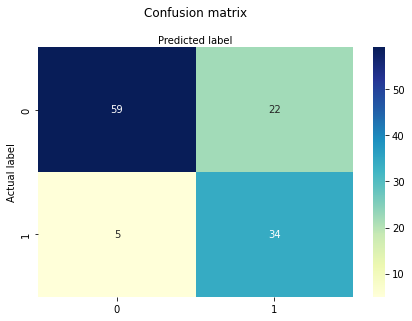

In [125]:
dtree_pred = pipeline.predict(X_test)
cnf = metrics.classification_report(y_test, dtree_pred)
print(cnf)
matrix = metrics.confusion_matrix(y_test, dtree_pred)
draw_confusion_matrix(matrix)

# Random Forest

In [25]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(max_features="sqrt",random_state=3,class_weight={0:0.22, 1: 0.78})
rf.fit(X_train, y_train)

RandomForestClassifier(class_weight={0: 0.22, 1: 0.78}, max_features='sqrt',
                       random_state=3)

Text(0, 0.5, 'Mean decrease in impurity')

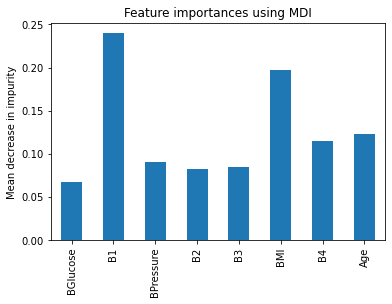

In [27]:
importances = rf.feature_importances_
forest_importances = pd.Series(importances, index=X.columns.values)
std = np.std([rf.feature_importances_ for tree in rf.estimators_], axis=0)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")

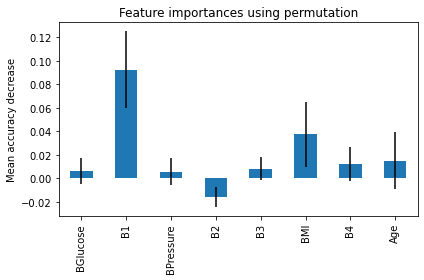

In [34]:
from sklearn.inspection import permutation_importance

result = permutation_importance(
    rf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)

forest_importances = pd.Series(result.importances_mean, index=X.columns.values)
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

In [29]:
from sklearn.metrics import roc_auc_score

rf_probs = rf.predict_proba(X_test)

rf_probs = rf_probs[:, 1]
rf_auc = roc_auc_score(y_test, rf_probs)
print('Random Forest: AUROC = %.3f' % (rf_auc))


Random Forest: AUROC = 0.819


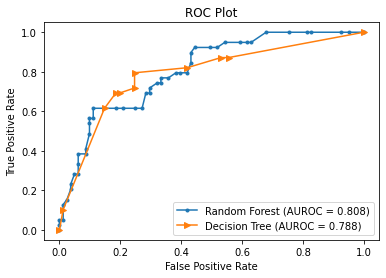

In [343]:
from sklearn.metrics import roc_curve, roc_auc_score

rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_probs, pos_label="Positive")
fpr, tpr, _ = roc_curve(y_test, f_probs,pos_label="Positive")
auc = roc_auc_score(y_test, f_probs)

plt.plot(rf_fpr, rf_tpr, marker='.', label='Random Forest (AUROC = %0.3f)' % rf_auc)
plt.plot(fpr, tpr, marker=">", label='Decision Tree (AUROC = %0.3f)' % auc)

# Title
plt.title('ROC Plot')
# Axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# Show legend
plt.legend() # 
# Show plot
plt.show()

In [30]:
from sklearn.metrics import roc_curve, roc_auc_score

rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_probs, pos_label="Negative")
fpr, tpr, _ = roc_curve(y_test, f_probs,pos_label="Negative")
auc = roc_auc_score(y_test, f_probs)

plt.plot(rf_fpr, rf_tpr, marker='.', label='Random Forest (AUROC = %0.3f)' % rf_auc)
plt.plot(fpr, tpr, marker=">", label='Decision Tree (AUROC = %0.3f)' % auc)

# Title
plt.title('ROC Plot')
# Axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# Show legend
plt.legend() # 
# Show plot
plt.show()

/Users/lap11353-local/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:751: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  y_true = y_true == pos_label


TypeError: 'bool' object is not subscriptable

              precision    recall  f1-score   support

           0       0.82      0.83      0.82        81
           1       0.63      0.62      0.62        39

    accuracy                           0.76       120
   macro avg       0.72      0.72      0.72       120
weighted avg       0.76      0.76      0.76       120



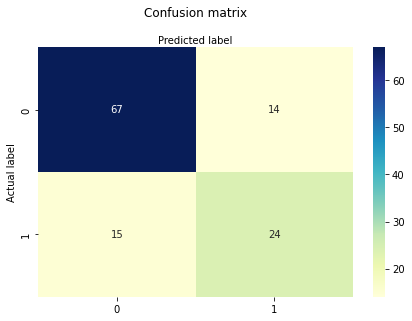

In [32]:
from sklearn.metrics import confusion_matrix, classification_report

fr_pred = rf.predict(X_test)
cnf_matrix = confusion_matrix(y_test, fr_pred)
draw_confusion_matrix(cnf_matrix)
print(classification_report(y_test, fr_pred))